In [12]:
from dataclasses import asdict
import math
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

from minitorch.module import LinearScalarLayer, LinearTensorLayer, ScalarNetwork, TensorNetwork
from minitorch.autodiff import Scalar
import minitorch.autodiff.tensor_functions as tf
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid
import minitorch.scalar_metrics as sm
import minitorch.scalar_losses as sl
import minitorch.tensor_losses as tl
import minitorch.tensor_metrics as tm

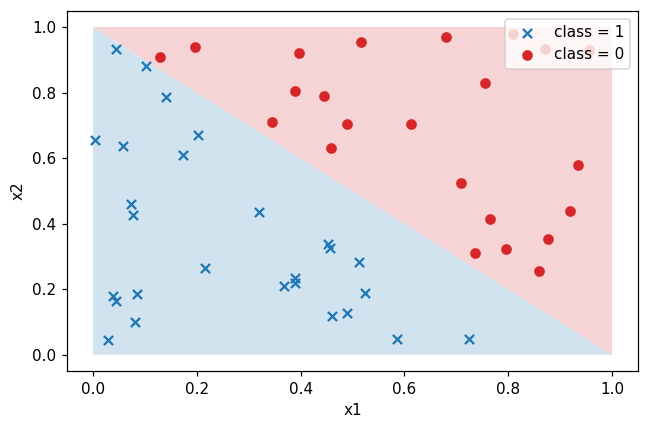

In [13]:
# Create a dataset
N_SAMPLES = 50
dataset_type = DatasetTypes.diagonal

datasets = Datasets.generate_datasets(n_samples=N_SAMPLES)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

bottom_left = Polygon([[0, 1], [1, 0], [0, 0]], color="tab:blue", alpha=0.2, lw=0.0)
top_right = Polygon([[0, 1], [1, 1], [1, 0]], color="tab:red", alpha=0.2, lw=0.0)
ax.add_patch(bottom_left)
ax.add_patch(top_right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout()

### Scalars

In [3]:
# Create a linear layer
network = LinearScalarLayer(input_dim=2, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.75)

# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [ ]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))

    # Compute a loss
    loss_per_epoch = sl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

In [ ]:
# Metrics
y_true = [Scalar(y_t) for y_t in y_true]
y_hat = [[scalar.sigmoid() for scalar in row] for row in network.forward(X)]
y_hat = list(itertools.chain.from_iterable(y_hat))

# Convert to classes using 0.5 threshold
y_hat_classes = [Scalar(1.0) if proba.data >= 0.5 else Scalar(0.0) for proba in y_hat]

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [sm.accuracy, sm.precision, sm.recall]
}

In [ ]:
# ROC Curve
tpr, fpr, thresholds = sm.roc_curve(y_true, y_hat, bucket_size=0.025)
tpr, fpr = [s.data for s in tpr], [s.data for s in fpr]

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve");

In [ ]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise decision boundary

bias_positions = list(np.linspace(0, 2, 101))
x_range = list(np.linspace(0, 1, 101))

for bias_lower, bias_upper in zip(bias_positions, bias_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1, bias_lower - x1)) for x1 in x_range]
    
    # Clamp values to between 0.0 and 1.0
    X_lower = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_lower]
    y_lower = network.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1, bias_upper - x1)) for x1 in x_range]
    
    # Clamp upper and lower bounds
    X_upper = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_upper]
    y_upper = network.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_between(
        x_range,
        [x2 for (_, x2) in X_lower],
        [x2 for (_, x2) in X_upper],
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )
    

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

### Tensors

In [14]:
# Create a linear layer
network = TensorNetwork(input_dim=2, hidden_dim = 5, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.005)

# Data
X = tf.tensor([list(x) for x in dataset.xs])
y_true = tf.tensor(dataset.ys).view(N_SAMPLES, 1)

In [15]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X).sigmoid()

    # Compute a loss
    loss_per_epoch = tl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.item())
    if epoch % 20 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.item()}")

epoch 0: loss = 0.7148544225923849
epoch 20: loss = 0.7220426698029915
epoch 40: loss = 0.7300127435331628


KeyboardInterrupt: 

In [9]:
# Metrics
y_true = y_true.view(y_true.size)
y_hat = network.forward(X).sigmoid()
y_hat_classes = (y_hat >= 0.5).view(y_hat.size)

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [tm.accuracy, tm.precision, tm.recall]
}

{'accuracy': 
 [0.52000],
 'precision': 
 [0.52000],
 'recall': 
 [1.00000]}